In [109]:
import pandas as pd
import requests
import sys
import numpy as np
import ast
import regex as re

In [125]:
lamberttfs = pd.read_csv("original_data/lambert_supp_tables.csv")
lamberttfs = lamberttfs[lamberttfs["Is TF?"] == "Yes"][["EnsemblId", "symbol"]]
lamberttfs.to_csv("lambert_tfs.csv")
lamberttfs.head()

,EnsemblId,symbol
1,ENSG00000137203,TFAP2A
2,ENSG00000008196,TFAP2B
3,ENSG00000087510,TFAP2C
4,ENSG00000008197,TFAP2D
5,ENSG00000116819,TFAP2E


In [126]:
ads = pd.read_csv("original_data/known_ADs_considering_isoforms_and_canonical.csv")
ads.head()

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes
0,ABRAXAS1,121,200,Q6UWZ7,[['Q6UWZ7']],ENST00000321945,Q6UWZ7,DelRosso et al.,CR,LQEHFSNQDLVFLLLTPSIITESCSTHRLEHSLYKPQKGLFHRVPL...,NaN
1,AEBP1,1088,1158,Q8IUX7,[['Q8IUX7']],NaN,Q8IUX7,Staller Activity Data,TF,EVVTEFGTEVEPEFGTKVEPEFETQLEPEFETQLEPEFEEEEEEEK...,NaN
2,AHCTF1,1445,1698,Q8WYP5,"[['Q8WYP5'], ['Q8WYP5']]",nan / nan,Q8WYP5 / Q8WYP5,"PMID: 11952839, Soto / transcriptionalactivity...",TF,IRANDNKSMADVLGDGGNSSLTISEGPIVSERRLNQEVALNLKEDH...,NaN
3,AHR,118,126,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,LLQALNGFV,NaN
4,AHR,266,268,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,FAI,NaN


In [127]:
rds = pd.read_csv("original_data/tycko_soto_delrosso_RD_coordinate_data.csv")
rds = rds.rename({" DBDs": "DBDs"}, axis=1)
rds["DBDs"] = [ast.literal_eval(x) for x in rds["DBDs"]]
rds.head()

,UniprotId,DBDs
0,A0A024R0Y4,"[(11, 90)]"
1,A0A087X169,"[(21, 140)]"
2,A0A0A0MRP6,"[(11, 140), (561, 650), (881, 960)]"
3,A0A0B4J2G0,"[(2, 81), (352, 431), (612, 731)]"
4,A0A0C4DFL8,"[(581, 700), (831, 910), (931, 1050)]"


In [128]:
#Want to get Ensembl IDs (unique gene) for each AD and RD, but some Uniprot IDs include the isoform type (xxxxx-1). Cleaning to remove, then do mapping with Uniprot mapper
ad_uniprotIDs = ads["uniprotID"]
rd_uniprotIDs = rds["UniprotId"]

ad_uniprotIDs = ad_uniprotIDs.apply(lambda s: re.match(r"^(.*?)-", s).group(1) if re.match(r"^(.*?)-", s) else s)
rd_uniprotIDs = rd_uniprotIDs.apply(lambda s: re.match(r"^(.*?)-", s).group(1) if re.match(r"^(.*?)-", s) else s)

ad_uniprotIDs.to_csv("helperdata/AD_uniprot.csv")
rd_uniprotIDs.to_csv("helperdata/RD_uniprot.csv")

Combining all TFs

In [129]:
protatlas_TFs = pd.read_csv("original_data/proteinatlas-TFs.tsv", sep="\t")[["Gene", "Ensembl"]]
protatlas_TFs.head()

,Gene,Ensembl
0,ADNP,ENSG00000101126
1,ADNP2,ENSG00000101544
2,AEBP2,ENSG00000139154
3,AHR,ENSG00000106546
4,AIRE,ENSG00000160224


In [130]:
lamberttfs = lamberttfs.rename({"EnsemblId": "Ensembl", "symbol": "Gene"}, axis = 1)
tfscombined = pd.concat([protatlas_TFs, lamberttfs]).drop_duplicates()
tfscombined = tfscombined.groupby("Ensembl").agg(lambda x: x.iloc[0] if len(x.iloc[0]) > 0 else None).reset_index()
print(len(tfscombined))
tfscombined.head()

1734


,Ensembl,Gene
0,DUX1_HUMAN,DUX1
1,DUX3_HUMAN,DUX3
2,ENSG00000001167,NFYA
3,ENSG00000004848,ARX
4,ENSG00000005073,HOXA11


In [131]:
lambert_tf_ensembl = set(lamberttfs["Ensembl"])
protatlas_tf_ensembl = set(protatlas_TFs["Ensembl"])
alltf_ensembl = set(list(lambert_tf_ensembl) + list(protatlas_tf_ensembl))
len(lambert_tf_ensembl), len(protatlas_tf_ensembl), len(alltf_ensembl)

(1639, 1485, 1734)

In [132]:
lamberttfs.head()

,Ensembl,Gene
1,ENSG00000137203,TFAP2A
2,ENSG00000008196,TFAP2B
3,ENSG00000087510,TFAP2C
4,ENSG00000008197,TFAP2D
5,ENSG00000116819,TFAP2E


---
# Processing AD and RD dfs

In [133]:
len(tfscombined["Gene"].unique()), len(ads["Gene"].unique()), len(rds["UniprotId"].unique())

(1733, 589, 1695)

In [145]:
#Get EnsemblIds for ADs and RDs using Uniprot ID mapper
ads_mapped = pd.read_csv("maps/ADs_mapped.tsv", sep="\t")
rds_mapped = pd.read_csv("maps/RDs_mapped.tsv", sep="\t")
ads_mapped["Bgee"] = ads_mapped["Bgee"].apply(lambda x:x.replace(";", "") if isinstance(x, str) else x)
rds_mapped["Bgee"] = rds_mapped["Bgee"].apply(lambda x:x.replace(";", "") if isinstance(x, str) else x)

#human only
ads_mapped_human = ads_mapped[["HUMAN" in x for x in ads_mapped["Entry Name"]]]
rds_mapped_human = rds_mapped[["HUMAN" in x for x in rds_mapped["Entry Name"]]]

len(ads_mapped["Bgee"].unique()), len(ads_mapped_human["Bgee"].unique()), len(rds_mapped["Bgee"].unique()), len(rds_mapped_human["Bgee"].unique())

(567, 567, 1655, 1655)

In [141]:
#Look at which ADs and RDs are not in the mapping
missingADs = ads[[not x in ads_mapped_human["Entry"].to_list() for x in ad_uniprotIDs]]
missingRDs = rds[[not x in rds_mapped_human["Entry"].to_list() for x in rd_uniprotIDs]]
print(len(missingADs), len(missingRDs))
missingADs

4 0


,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes
693,VP16,411,490,P06492,[['P06492']],NaN,P06492 / P06492 / P06492 / P06492,"nan / nan / nan / nan, GSL",TF,STAPPTDVSLGDELHLDGEDVAMAHADALDDFDLDMLGDGDSPGPG...,NaN
730,ZNF469,2892,2971,H3BS19,[['H3BS19']],ENST00000565624,H3BS19,DelRosso et al.,TF,QPSFEEGGDPTLGPARLPTDLSDSSSLCLCHEDPWEDEDPAGLPES...,NaN
731,ZNF469,3002,3091,H3BS19,[['H3BS19']],ENST00000565624,H3BS19,DelRosso et al.,TF,MPAPADDSSSSLGDVSPEPPSLERERCDGGLPGNTHLLPLRATDFE...,NaN
732,ZNF469,792,911,H3BS19,"[['H3BS19'], ['H3BS19']]",ENST00000565624 / ENST00000565624,H3BS19 / H3BS19,DelRosso et al. / DelRosso et al.,TF,SHAKTFLLAGDAQAEGKDDPLRTGFLPSLAATPFPLPASDLDMEDD...,NaN


In [138]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

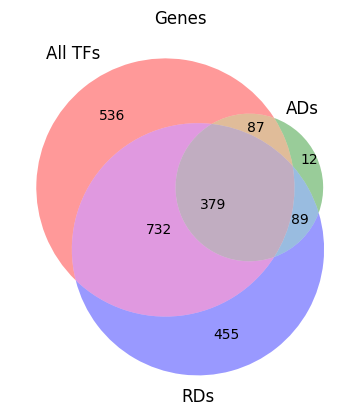

In [146]:
#venn diagram of TFs, ADs, RDs using EnsemblId

alltf_ensembl = set(tfscombined["Ensembl"].unique())
ads_ensembl = set(ads_mapped_human["Bgee"].unique())
rds_ensembl = set(rds_mapped_human["Bgee"].unique())

venn3([alltf_ensembl, ads_ensembl, rds_ensembl], ["All TFs", "ADs", "RDs"])
plt.title("Genes")
plt.savefig("figures/TF_AD_RD_composition.png")

In [148]:
ads_mapped

,From,Entry,Entry Name,Protein names,Gene Names,Sequence,Bgee,Ensembl,GeneID,PDB,Reviewed,Motif,Protein families,Domain [CC],Domain [FT],Compositional bias,Sequence similarities,BioGRID,Post-translational modification
0,Q6UWZ7,Q6UWZ7,ABRX1_HUMAN,BRCA1-A complex subunit Abraxas 1 (Coiled-coil...,ABRAXAS1 ABRA1 CCDC98 FAM175A UNQ496/PRO1013,MEGESTSAVLSGFVLGALAFQHLNTDSDTEGFLLGEVKGEAKNSIT...,ENSG00000163322,ENST00000321945.12 [Q6UWZ7-1];,84142;,4JLU;4U4A;4Y18;4Y2G;,reviewed,"MOTIF 406..409; /note=""pSXXF motif""; /evidence...","FAM175 family, Abraxas subfamily",NaN,"DOMAIN 7..160; /note=""MPN""; /evidence=""ECO:000...","COMPBIAS 385..400; /note=""Basic and acidic res...",SIMILARITY: Belongs to the FAM175 family. Abra...,123911;,PTM: Phosphorylation of Ser-406 of the pSXXF m...
1,Q8IUX7,Q8IUX7,AEBP1_HUMAN,Adipocyte enhancer-binding protein 1 (AE-bindi...,AEBP1 ACLP,MAAVRGAPLLSCLLALLALCPGGRPQTVLTDDEIEEFLEGFLSELE...,ENSG00000106624,ENST00000223357.8 [Q8IUX7-1];ENST00000450684.2...,165;,NaN,reviewed,NaN,Peptidase M14 family,DOMAIN: [Isoform 1]: The F5/8 type C domain bi...,"DOMAIN 383..540; /note=""F5/8 type C""; /evidenc...","COMPBIAS 43..58; /note=""Basic and acidic resid...",SIMILARITY: Belongs to the peptidase M14 famil...,106674;,PTM: Phosphorylated by MAPK1 in vitro. {ECO:00...
2,Q8WYP5,Q8WYP5,ELYS_HUMAN,Protein ELYS (Embryonic large molecule derived...,AHCTF1 ELYS TMBS62 MSTP108,MRDLRAQVTSGLLPFPEVTLQALGEDEITLESVLRGKFAAGKNGLA...,ENSG00000153207,ENST00000326225.3 [Q8WYP5-3];ENST00000366508.5...,25909;,7R5J;7R5K;,reviewed,NaN,ELYS family,DOMAIN: The N-terminus forms a highly conserve...,NaN,"COMPBIAS 1207..1225; /note=""Polar residues""; /...",SIMILARITY: Belongs to the ELYS family. {ECO:0...,117414;,NaN
3,P35869,P35869,AHR_HUMAN,Aryl hydrocarbon receptor (Ah receptor) (AhR) ...,AHR BHLHE76,MNSSSANITYASRKRRKPVQKTVKPIPAEGIKSNPSKRHRDRLNTE...,ENSG00000106546,ENST00000242057.9;ENST00000463496.1;,196;,5NJ8;7ZUB;8QMO;,reviewed,"MOTIF 13..16; /note=""Nuclear localization sign...",NaN,DOMAIN: The PAS 1 domain is essential for dime...,"DOMAIN 27..80; /note=""bHLH""; /evidence=""ECO:00...",NaN,NaN,106699;,"PTM: Mono-ADP-ribosylated, leading to inhibit ..."
4,O43918,O43918,AIRE_HUMAN,Autoimmune regulator (Autoimmune polyendocrino...,AIRE APECED,MATDAALRRLLRLHRTEIAVAVDSAFPLLHALADHDVVPEDKFQET...,ENSG00000160224,ENST00000291582.6 [O43918-1];,326;,1XWH;2KE1;2KFT;2LRI;,reviewed,"MOTIF 7..11; /note=""LXXLL motif 1""; MOTIF 63.....",NaN,DOMAIN: The L-X-X-L-L repeats may be implicate...,"DOMAIN 1..105; /note=""HSR""; /evidence=""ECO:000...",NaN,NaN,106823;,PTM: Phosphorylated. Phosphorylation could tri...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,Q8N1G0,Q8N1G0,ZN687_HUMAN,Zinc finger protein 687,ZNF687 KIAA1441,MGDMKTPDFDDLLAAFDIPDIDANEAIHSGPEENEGPGGPGKPEPG...,ENSG00000143373,ENST00000324048.9 [Q8N1G0-1];ENST00000336715.1...,57592;,NaN,reviewed,NaN,Krueppel C2H2-type zinc-finger protein family,NaN,NaN,"COMPBIAS 172..191; /note=""Pro residues""; /evid...",SIMILARITY: Belongs to the krueppel C2H2-type ...,121643;,NaN
566,P17040,P17040,ZSC20_HUMAN,Zinc finger and SCAN domain-containing protein...,ZSCAN20 KOX29 ZNF31 ZNF360,MAMALELQAQASPQPEPEELLIVKLEEDSWGSESKLWEKDRGSVSG...,ENSG00000121903,ENST00000361328.7 [P17040-1];ENST00000373413.2...,7579;,NaN,reviewed,NaN,Krueppel C2H2-type zinc-finger protein family,NaN,"DOMAIN 51..133; /note=""SCAN box""; /evidence=""E...","COMPBIAS 30..46; /note=""Basic and acidic resid...",SIMILARITY: Belongs to the krueppel C2H2-type ...,113408;,NaN
567,P98168,P98168,ZXDA_HUMAN,Zinc finger X-linked protein ZXDA,ZXDA,MEIPKLLPARGTLQGGGGGGIPAGGGRVHRGPDSPAGQVPTRRLLL...,ENSG00000198205,ENST00000358697.6;,7789;,NaN,reviewed,NaN,ZXD family,NaN,NaN,NaN,SIMILARITY: Belongs to the ZXD family. {ECO:00...,113568;,NaN
568,P98169,P98169,ZXDB_HUMAN,Zinc finger X-linked protein ZXDB,ZXDB,MEIPKLLPARGTLQGGGGGGIPAGGGRVHRGPDSPAGQVPTRRLLL...,ENSG00000198455,ENST00000374888.3;,158586;,NaN,reviewed,NaN,ZXD f

In [149]:
#Export human TFs
tfscombined.to_csv("helperdata/tfs_combined.csv")

---
### old

In [9]:
combined_uniprot = tfs["symbol"].to_list()
combined_uniprot += ads["uniprotID"].to_list()
combined_uniprot += rds["UniprotId"].to_list()
#pd.Series(combined_uniprot).drop_duplicates().to_csv("uniprotnames.csv")

In [11]:
adsmapped = ads.merge(tfsmapped, left_on="uniprotID", right_on="Entry")
rdsmapped = rds.merge(tfsmapped, left_on="UniprotId", right_on="Entry")
lambertf = tfs.merge(tfsmapped, left_on="EnsemblId", right_on="From")

print(len(adsmapped), len(ads))
print(len(rdsmapped), len(rds))
print(len(lambertf), len(tfs))

613 744
1070 1695
6170 1639


In [12]:
len(tfsmapped)

6170

In [13]:
rd_ENSG_dict = rds.merge(tfsmapped, left_on="UniprotId", right_on="Entry")[["From", "Entry"]].set_index("From")["Entry"].to_dict()
ad_ENSG_dict = ads.merge(tfsmapped, left_on="uniprotID", right_on="Entry")[["From", "Entry"]].set_index("From")["Entry"].to_dict()
tfs_ENSG_dict = tfs.set_index("EnsemblId")["symbol"].to_dict()

rd_ENSG = set(rd_ENSG_dict.keys())
ad_ENSG = set(ad_ENSG_dict.keys())
tfs_ENSG = tfs.merge(tfsmapped, left_on="EnsemblId", right_on="From")["From"].unique()
reviewed_ENSG = set(tfsmapped[tfsmapped["Reviewed"] == "reviewed"]["From"].to_list())

combined_ENSG_list = set(list(rd_ENSG) + list(ad_ENSG) + list(tfs_ENSG))
unreviewed_ENSG = [item for item in combined_list if item not in reviewed_ENSG]

len(unreviewed_ENSG), len(reviewed_ENSG), len(set(combined_list))

NameError: name 'combined_list' is not defined

In [221]:
#adsmapped.to_csv("ADS_mapped.csv")
#rdsmapped.to_csv("RDs_mapped.csv")

,UniprotId,DBDs,From,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Tissue specificity,Motif,Protein families,Compositional bias,Sequence similarities,Bgee,ExpressionAtlas
0,A0A087X169,"[(21, 140)]",ENSG00000119403,A0A087X169,unreviewed,A0A087X169_HUMAN,PHD finger protein 19,PHF19,Homo sapiens (Human),599,NaN,NaN,Polycomblike family,NaN,SIMILARITY: Belongs to the Polycomblike family...,ENSG00000119403; Expressed in ventricular zone...,A0A087X169; baseline and differential.;
1,A0A0B4J2G0,"[(2, 81), (352, 431), (612, 731)]",ENSG00000196247,A0A0B4J2G0,unreviewed,A0A0B4J2G0_HUMAN,Zinc finger protein 107,ZNF107,Homo sapiens (Human),852,NaN,NaN,NaN,NaN,NaN,ENSG00000196247; Expressed in secondary oocyte...,A0A0B4J2G0; baseline and differential.;
2,A0A0C4DFQ2,"[(102, 181), (192, 311), (362, 441)]",ENSG00000177125,A0A0C4DFQ2,unreviewed,A0A0C4DFQ2_HUMAN,Zinc finger and BTB domain containing 34,ZBTB34,Homo sapiens (Human),504,NaN,NaN,NaN,"COMPBIAS 170..193; /note=""Polar residues""; /ev...",NaN,ENSG00000177125; Expressed in amniotic fluid a...,A0A0C4DFQ2; baseline and differential.;
3,A0A0C4DH12,"[(32, 111), (142, 261)]",ENSG00000102984,A0A0C4DH12,unreviewed,A0A0C4DH12_HUMAN,Zinc finger protein 821,ZNF821,Homo sapiens (Human),370,NaN,NaN,NaN,"COMPBIAS 25..41; /note=""Basic and acidic resid...",NaN,ENSG00000102984; Expressed in cortical plate a...,NaN
4,A0A0D9SEJ8,"[(2, 101)]",ENSG00000275004,A0A0D9SEJ8,unreviewed,A0A0D9SEJ8_HUMAN,Suppressor of hairy wing homolog 2 (Drosophila...,ZNF280B SUHW2 hCG_1783609,Homo sapiens (Human),543,NaN,NaN,NaN,"COMPBIAS 8..23; /note=""Basic and acidic residu...",NaN,ENSG00000275004; Expressed in male germ line s...,A0A0D9SEJ8; baseline and differential.;


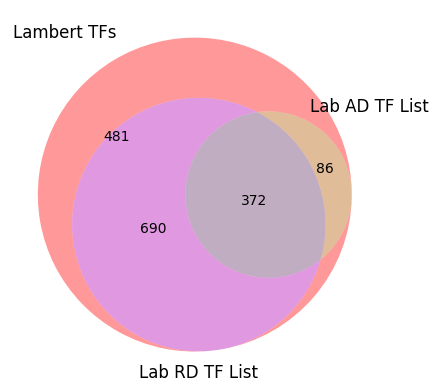

In [178]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

venn3(subsets = (set(tfs_ENSG), set(ad_ENSG), set(rd_ENSG)),set_labels = ('Lambert TFs', 'Lab AD TF List', 'Lab RD TF List'))

plt.savefig("TFcountsvenn.png")

In [179]:
rd_unreviewed = [rd_ENSG_dict[i] for i in unreviewed_ENSG if i in rd_ENSG_dict.keys()]
ad_unreviewed = [ad_ENSG_dict[i] for i in unreviewed_ENSG  if i in ad_ENSG_dict.keys()]
tf_unreviewed = [tfs_ENSG_dict[i] for i in unreviewed_ENSG  if i in tfs_ENSG_dict.keys()]
all_unreviewed = list(set(rd_unreviewed + ad_unreviewed + tf_unreviewed))

unreviewed_df = tfsmapped[[item in unreviewed_ENSG for item in tfsmapped["From"]]]
unreviewed_df = unreviewed_df[[item in all_unreviewed for item in unreviewed_df["Entry"]]]

In [217]:
tfsmapped[[i in combined_list for i in tfsmapped["From"]]]

,From,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Tissue specificity,Motif,Protein families,Compositional bias,Sequence similarities,Bgee,ExpressionAtlas
0,ENSG00000137203,P05549,reviewed,AP2A_HUMAN,Transcription factor AP-2-alpha (AP2-alpha) (A...,TFAP2A AP2TF TFAP2,Homo sapiens (Human),437,NaN,"MOTIF 57..62; /note=""PPxY motif""",AP-2 family,"COMPBIAS 23..48; /note=""Polar residues""; /evid...",SIMILARITY: Belongs to the AP-2 family. {ECO:0...,ENSG00000137203; Expressed in upper leg skin a...,P05549; baseline and differential.;
1,ENSG00000137203,A0A6E1XE14,unreviewed,A0A6E1XE14_HUMAN,Transcription factor AP-2-alpha (AP-2 transcri...,TFAP2A hCG_37170,Homo sapiens (Human),439,NaN,NaN,AP-2 family,"COMPBIAS 25..50; /note=""Polar residues""; /evid...",SIMILARITY: Belongs to the AP-2 family. {ECO:0...,ENSG00000137203; Expressed in upper leg skin a...,NaN
2,ENSG00000137203,C1K3N0,unreviewed,C1K3N0_HUMAN,Transcription factor AP-2-alpha (AP-2 transcri...,TFAP2A,Homo sapiens (Human),328,NaN,NaN,AP-2 family,"COMPBIAS 23..48; /note=""Polar residues""; /evid...",SIMILARITY: Belongs to the AP-2 family. {ECO:0...,ENSG00000137203; Expressed in upper leg skin a...,NaN
3,ENSG00000137203,C9J6N8,unreviewed,C9J6N8_HUMAN,Transcription factor AP-2 alpha,TFAP2A,Homo sapiens (Human),173,NaN,NaN,NaN,"COMPBIAS 7..22; /note=""Polar residues""; /evide...",NaN,ENSG00000137203; Expressed in upper leg skin a...,C9J6N8; baseline and differential.;
4,ENSG00000137203,C9JXZ2,unreviewed,C9JXZ2_HUMAN,Transcription factor AP-2 alpha,TFAP2A,Homo sapiens (Human),136,NaN,NaN,AP-2 family,NaN,SIMILARITY: Belongs to the AP-2 family. {ECO:0...,ENSG00000137203; Expressed in upper leg skin a...,C9JXZ2; baseline and differential.;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6165,ENSG00000168152,D6R957,unreviewed,D6R957_HUMAN,THAP domain containing 9,THAP9,Homo sapiens (Human),30,NaN,NaN,NaN,NaN,NaN,ENSG00000168152; Expressed in sperm and 130 ot...,D6R957; baseline and differential.;
6166,ENSG00000168152,D6RCT5,unreviewed,D6RCT5_HUMAN,THAP domain containing 9,THAP9,Homo sapiens (Human),102,NaN,NaN,NaN,NaN,NaN,ENSG00000168152; Expressed in sperm and 130 ot...,D6RCT5; baseline and differential.;
6167,ENSG00000168152,D6REM3,unreviewed,D6REM3_HUMAN,THAP domain containing 9,THAP9,Homo sapiens (Human),109,NaN,NaN,NaN,NaN,NaN,ENSG00000168152; Expressed in sperm and 130 ot...,D6REM3; baseline and differential.;
6168,ENSG00000168152,F2Z371,unreviewed,F2Z371_HUMAN,THAP domain containing 9,THAP9,Homo sapiens (Human),102,NaN,NaN,NaN,NaN,NaN,ENSG00000168152; Expressed in sperm and 130 ot...,F2Z371; baseline and differential.;


In [204]:
allTF_df = pd.concat([tfsmapped[tfsmapped["Reviewed"] == "reviewed"], unreviewed_df]).set_index("From")
allTF_df = allTF_df.drop_duplicates()
allTF_df.head()

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Tissue specificity,Motif,Protein families,Compositional bias,Sequence similarities,Bgee,ExpressionAtlas
From,,,,,,,,,,,,,,
ENSG00000137203,P05549,reviewed,AP2A_HUMAN,Transcription factor AP-2-alpha (AP2-alpha) (A...,TFAP2A AP2TF TFAP2,Homo sapiens (Human),437,NaN,"MOTIF 57..62; /note=""PPxY motif""",AP-2 family,"COMPBIAS 23..48; /note=""Polar residues""; /evid...",SIMILARITY: Belongs to the AP-2 family. {ECO:0...,ENSG00000137203; Expressed in upper leg skin a...,P05549; baseline and differential.;
ENSG00000008196,Q92481,reviewed,AP2B_HUMAN,Transcription factor AP-2-beta (AP2-beta) (Act...,TFAP2B,Homo sapiens (Human),460,NaN,NaN,AP-2 family,"COMPBIAS 36..60; /note=""Polar residues""; /evid...",SIMILARITY: Belongs to the AP-2 family. {ECO:0...,ENSG00000008196; Expressed in corpus epididymi...,Q92481; baseline and differential.;
ENSG00000087510,Q92754,reviewed,AP2C_HUMAN,Transcription factor AP-2 gamma (AP2-gamma) (A...,TFAP2C,Homo sapiens (Human),450,NaN,"MOTIF 59..64; /note=""PPxY motif""",AP-2 family,"COMPBIAS 92..107; /note=""Polar residues""; /evi...",SIMILARITY: Belongs to the AP-2 family. {ECO:0...,ENSG00000087510; Expressed in endometrium epit...,Q92754; baseline and differential.;
ENSG00000008197,Q7Z6R9,reviewed,AP2D_HUMAN,Transcription factor AP-2-delta (AP2-delta) (A...,TFAP2D TFAP2BL1,Homo sapiens (Human),452,"TISSUE SPECIFICITY: Highly expressed in brain,...",NaN,AP-2 family,"COMPBIAS 433..452; /note=""Basic and acidic res...",SIMILARITY: Belongs to the AP-2 family. {ECO:0...,ENSG00000008197; Expressed in oocyte and 23 ot...,NaN
ENSG00000116819,Q6VUC0,reviewed,AP2E_HUMAN,Transcription factor AP-2-epsilon (AP2-epsilon...,TFAP2E,Homo sapiens (Human),442,"TISSUE SPECIFICITY: Expressed in skin, primary...","MOTIF 54..59; /note=""PPxY motif""; /evidence=""E...",AP-2 family,NaN,SIMILARITY: Belongs to the AP-2 family. {ECO:0...,ENSG00000116819; Expressed in cerebellar hemis...,NaN


In [198]:
def ad_rd_annotate(uniprot):
    ad, rd, both = False, False, False
    if uniprot in ad_ENSG_dict.values():
        ad = True
    if uniprot in rd_ENSG_dict.values():
        rd = True
        if ad:
            both = True
    return ad, rd, both

isAD = []
isRD = []
isboth = []
for uniprot in allTF_df["Entry"]:
    ad, rd, both = ad_rd_annotate(uniprot)
    isAD.append(ad)
    isRD.append(rd)
    isboth.append(both)

allTF_df["is AD"] = isAD
allTF_df["is RD"] = isRD
allTF_df["is AD and RD"] = isboth

allTF_df.head()

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Tissue specificity,Motif,Protein families,Compositional bias,Sequence similarities,Bgee,ExpressionAtlas,is AD,is RD,is AD and RD
From,,,,,,,,,,,,,,,,,
ENSG00000137203,P05549,reviewed,AP2A_HUMAN,Transcription factor AP-2-alpha (AP2-alpha) (A...,TFAP2A AP2TF TFAP2,Homo sapiens (Human),437,NaN,"MOTIF 57..62; /note=""PPxY motif""",AP-2 family,"COMPBIAS 23..48; /note=""Polar residues""; /evid...",SIMILARITY: Belongs to the AP-2 family. {ECO:0...,ENSG00000137203; Expressed in upper leg skin a...,P05549; baseline and differential.;,True,False,False
ENSG00000008196,Q92481,reviewed,AP2B_HUMAN,Transcription factor AP-2-beta (AP2-beta) (Act...,TFAP2B,Homo sapiens (Human),460,NaN,NaN,AP-2 family,"COMPBIAS 36..60; /note=""Polar residues""; /evid...",SIMILARITY: Belongs to the AP-2 family. {ECO:0...,ENSG00000008196; Expressed in corpus epididymi...,Q92481; baseline and differential.;,True,True,True
ENSG00000087510,Q92754,reviewed,AP2C_HUMAN,Transcription factor AP-2 gamma (AP2-gamma) (A...,TFAP2C,Homo sapiens (Human),450,NaN,"MOTIF 59..64; /note=""PPxY motif""",AP-2 family,"COMPBIAS 92..107; /note=""Polar residues""; /evi...",SIMILARITY: Belongs to the AP-2 family. {ECO:0...,ENSG00000087510; Expressed in endometrium epit...,Q92754; baseline and differential.;,True,True,True
ENSG00000008197,Q7Z6R9,reviewed,AP2D_HUMAN,Transcription factor AP-2-delta (AP2-delta) (A...,TFAP2D TFAP2BL1,Homo sapiens (Human),452,"TISSUE SPECIFICITY: Highly expressed in brain,...",NaN,AP-2 family,"COMPBIAS 433..452; /note=""Basic and acidic res...",SIMILARITY: Belongs to the AP-2 family. {ECO:0...,ENSG00000008197; Expressed in oocyte and 23 ot...,NaN,True,False,False
ENSG00000116819,Q6VUC0,reviewed,AP2E_HUMAN,Transcription factor AP-2-epsilon (AP2-epsilon...,TFAP2E,Homo sapiens (Human),442,"TISSUE SPECIFICITY: Expressed in skin, primary...","MOTIF 54..59; /note=""PPxY motif""; /evidence=""E...",AP-2 family,NaN,SIMILARITY: Belongs to the AP-2 family. {ECO:0...,ENSG00000116819; Expressed in cerebellar hemis...,NaN,False,False,False


In [206]:
duplicate_indices = allTF_df.index[allTF_df.index.duplicated(keep=False)]

# Filter rows with duplicate indices
duplicate_rows = allTF_df.loc[duplicate_indices]
duplicate_rows

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Tissue specificity,Motif,Protein families,Compositional bias,Sequence similarities,Bgee,ExpressionAtlas
From,,,,,,,,,,,,,,
ENSG00000257923,P39880,reviewed,CUX1_HUMAN,Homeobox protein cut-like 1 (CCAAT displacemen...,CUX1 CUTL1,Homo sapiens (Human),1505,NaN,NaN,CUT homeobox family,"COMPBIAS 437..455; /note=""Polar residues""; /ev...",SIMILARITY: Belongs to the CUT homeobox family...,ENSG00000257923; Expressed in secondary oocyte...,P39880; baseline and differential.;
ENSG00000257923,Q13948,reviewed,CASP_HUMAN,Protein CASP,CUX1 CUTL1,Homo sapiens (Human),678,NaN,NaN,CASP family,NaN,SIMILARITY: Belongs to the CASP family. {ECO:0...,ENSG00000257923; Expressed in secondary oocyte...,Q13948; baseline and differential.;
ENSG00000257923,P39880,reviewed,CUX1_HUMAN,Homeobox protein cut-like 1 (CCAAT displacemen...,CUX1 CUTL1,Homo sapiens (Human),1505,NaN,NaN,CUT homeobox family,"COMPBIAS 437..455; /note=""Polar residues""; /ev...",SIMILARITY: Belongs to the CUT homeobox family...,ENSG00000257923; Expressed in secondary oocyte...,P39880; baseline and differential.;
ENSG00000257923,Q13948,reviewed,CASP_HUMAN,Protein CASP,CUX1 CUTL1,Homo sapiens (Human),678,NaN,NaN,CASP family,NaN,SIMILARITY: Belongs to the CASP family. {ECO:0...,ENSG00000257923; Expressed in secondary oocyte...,Q13948; baseline and differential.;


In [200]:
len(allTF_df), len(allTF_df.index.unique()), len(allTF_df["Entry"].unique())

(1621, 1620, 1621)

---

In [186]:
%%script echo
def ad_rd_annotate(uniprot):
    numads = len(ads[ads["uniprotID"] == uniprot])
    numrds = len(rds[rds["UniprotId"] == uniprot])
    if numads + numrds == 0:
        classification = "none"
    elif (numads > 0) and (numrds > 0):
        classification = "both"
    elif numads > 0:
        classification = "AD only"
    elif numrds > 0:
        classification = "RD only"
    return numads, numrds, classification

numadslist = []
numrdslist = []
classificationlist = []
for uniprot in allTF_df["Entry"]:
    numads, numrds, classification = ad_rd_annotate(uniprot)
    numadslist.append(numads)
    numrdslist.append(numrds)
    classificationlist.append(classification)

allTF_df["num ADs"] = numadslist
allTF_df["num RDs"] = numrdslist
allTF_df["classification"] = classificationlist

allTF_df.head()

---

In [35]:
tfsmapped["classification"].value_counts()

classification
none       5010
RD only     701
both        369
AD only      90
Name: count, dtype: int64

In [ ]:
%%skip
def gtex_getgenecode(ensemblid):
    server = "https://gtexportal.org/api/v2/reference/gene?"
    ext = "geneId=" + ensemblid
    r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})
    if not r.ok:
        r.raise_for_status()
        sys.exit()
    
    decoded = r.json()

    return decoded["data"][0]["gencodeId"]

tfsmapped["gencodeId"] = tfsmapped["From"].apply(gtex_getgenecode)
tfsmapped.to_csv("tfsmapped-gencodes.csv")

In [ ]:
%%skip
def gtex_fullexpression(ensemblid):
    server = "https://gtexportal.org/api/v2/expression/geneExpression?"
    ext = "gencodeId=" + ensemblid
    r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})
    if not r.ok:
        r.raise_for_status()
        sys.exit()
    
    decoded = r.json()

    return pd.DataFrame(decoded["data"])


def gtex_fullexpression_clean(ensemblid, save_csv, dirstring):
    """
    Ensemblid: 
    Save_csv (boolean): 
    dirstring (string): directory to save the csv into
    value (string): 1D df of mean, median, std, count from the expression results to return
    """
    fulldf = gtex_fullexpression(ensemblid)

    newdf = fulldf[["tissueSiteDetailId"]].set_index("tissueSiteDetailId")
    newdf["mean"] = fulldf["data"].apply(np.mean).to_list()
    newdf["median"] = fulldf["data"].apply(np.mean).to_list()
    newdf["std"] = fulldf["data"].apply(np.std).to_list()
    newdf["count"] = fulldf["data"].apply(len).to_list()
    
    def select_df(label):
        return newdf[[label]].rename({label: ensemblid}, axis=1)

    if save_csv:
        newdf.to_csv(dirstring + ensemblid + "_expression.csv")

    return select_df("mean"), select_df("median"), select_df("std"), select_df("count")


################## Run on TFs

means, medians, stds, counts = pd.DataFrame({}), pd.DataFrame({}), pd.DataFrame({}), pd.DataFrame({})

for ensemblId in tfsmapped["gencodeId"].unique():
    try:
        mean_i, median_i, std_i, count_i = gtex_fullexpression_clean(ensemblId, False, "TF_expression/")
        means = means.join(mean_i, how = "outer")
        medians = medians.join(median_i, how = "outer")
        stds = stds.join(std_i, how = "outer")
        counts = counts.join(count_i, how = "outer")
    except:
        print(ensemblId + "error")

means.to_csv("ensemblId_mean.csv")
medians.to_csv("ensemblId_median.csv")
stds.to_csv("ensemblId_stds.csv")
counts.to_csv("ensemblId_counts.csv")

ENSG00000267281.2error
ENSG00000267179.1error
ENSG00000264668.1error
ENSG00000100146.16error
ENSG00000064489.22error
